In [9]:
!pip install scikit-learn

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
from hand_tracker import HandTracker
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline
palm_model_path = "./models/palm_detection.tflite"
landmark_model_path = "./models/hand_landmark.tflite"
anchors_path = "./data/anchors.csv" 

C:\Users\mvorr\Documents\Projects\cvhandrehab\hand_tracker.py:95: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x) )


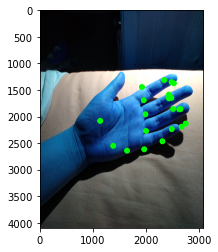

In [14]:
#test hand pose estimation
img = cv2.imread('./data/test_img.jpg', -1)

detector = HandTracker(palm_model_path, landmark_model_path, anchors_path,
                       box_shift=0.2, box_enlarge=1.3)

kp,box = detector(img)

for k in kp:
    cv2.circle(img, (int(k[0]), int(k[1])), 30, (0,255,0), thickness=50)

plt.imshow(img)

## Convenience Functions

In [17]:
from sklearn import preprocessing
import pickle

# POSE ARRAY ACCESS: 
# poses[frame, keypoint, coordinate]
# Examples: 
# 

"""Scale the pose array to be between -1 and 1"""
def preprocess(n):
#     n = smooth(n)
    for k in range(21):
        n[:,k,:] = preprocessing.scale(n[:,k,:])
    return n

"""Loads a pose array from file and applies preprocessing"""
def load_poses(fname):
    with open(fname,'rb') as f:
        pose_sequence = preprocess(np.array(pickle.load(f)))
    return pose_sequence

"""Load a dictionary containing pose arrays addressable by exercise and group
    Example: data['mug']['bad'] = [t1_poses, t2_poses, t3_poses]
"""
def load_set():
    exercises = ['mug', 'bottle', 'cap']
    groups = ['bad', 'norm', 'worst']
    
    data = dict.fromkeys(exercises, None)
    for key in data: 
        data[key] = dict.fromkeys(groups,None)
    
    for e in exercises:
        for p in groups:
            
            for i in range(3): 
                poses = load_poses(fname=f'./poses/{e}/{p}/{p}{i}.pose')
                
                if data[e][p] is None: 
                    data[e][p] = [poses]
                else: 
                    data[e][p].append(poses) 
                
                if e=='mug' and p=='bad':
                    l = len(data[e][p])
                  
    return data

In [18]:
poses = load_set()
poses['bottle']['norm'] 

[array([[[-0.09804806, -0.94161286],
         [-0.13873958, -0.89771544],
         [-0.16421815, -0.86328753],
         ...,
         [-0.23361552, -1.07963726],
         [-0.27914447, -1.03675007],
         [-0.31142572, -0.8931025 ]],
 
        [[-0.09602839, -0.97222075],
         [-0.13625409, -0.90797026],
         [-0.16624044, -0.87871908],
         ...,
         [-0.23220244, -1.10509896],
         [-0.2802572 , -1.06632355],
         [-0.31538888, -0.93054264]],
 
        [[-0.10047535, -0.95320911],
         [-0.13894667, -0.8717627 ],
         [-0.16832021, -0.827665  ],
         ...,
         [-0.23365806, -1.10205853],
         [-0.28152724, -1.06317053],
         [-0.31763867, -0.92916781]],
 
        ...,
 
        [[-0.16920057, -1.53158657],
         [-0.20160475, -1.5517753 ],
         [-0.20299801, -1.62172873],
         ...,
         [-0.28434449, -1.71225892],
         [-0.33465641, -1.71028992],
         [-0.37054108, -1.60293339]],
 
        [[-0.16961639, -1.550

In [64]:
#operations
from fastdtw import fastdtw 
from scipy.signal import savgol_filter
#Dynamic time warping distance between pose sequences `a` and `b` given a keypoint
def dtw_dist(a,b,kp=0): 
    dist,path = fastdtw(b[:,kp,:], a[:,kp,:], dist=euclidean)
    return dist

#Normalized jerk score given x and y position data 
def njs(data, kp=0): 
    x,y = data[:,kp,0], data[:,kp,1] 
    l = len(x) / 30 
    d = 1/30
    A = (d**5) / (l**2)
    jx,jy = np.diff(x, n=3), np.diff(y, n=3) 
    
    njx, njy = (0.5*np.sum(jx**2 * (A)))**0.5, (0.5*np.sum(jy**2) * A)**0.5
    
    return njx, njy
#     return np.around(njx,1),np.around(njy,1)
def split_njs(data, k=3, kp=0):
    s = np.array_split(data, k)
    return [(a,njs(a,kp=kp)) for a in s]
    
#Savitzky-Golay Filtering
def smooth(data, m=9,n=3): 
    filtered = data.copy()
    for i in range(21): 
        filtered[:,i,0] = savgol_filter(data[:,i,0], m, n)
        filtered[:,i,1] = savgol_filter(data[:,i,1], m, n)
    return filtered

In [65]:
#plotting
from matplotlib.lines import Line2D

def plot_trajectory(a,kp=0,color='green',line=False):
    x,y = a[:,kp,0], a[:,kp,1]

    if line:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_xlim(min(x), max(x))
        ax.set_ylim(min(y), max(y))

        line = Line2D(x,y,c=color) 
        ax.add_line(line)
        plt.show()
    else:
        plt.scatter(x,y,c=color,s=2)
        plt.show()    

## Load Data

In [66]:
# # testing pose loading
# d = load_poses('./poses/norm/norm2.pose')
# plot_trajectory(d)
data = load_set() # data['ball']['bad'] = [bad1_pose,bad2_pose,..]
b = data['mug']['bad'][0]
print(b.shape)
s = split_njs(b)

(678, 21, 2)


In [67]:
p = data['mug']['bad'][0]
njs(p)

(0.00015858538974833545, 0.0006014335246335525)

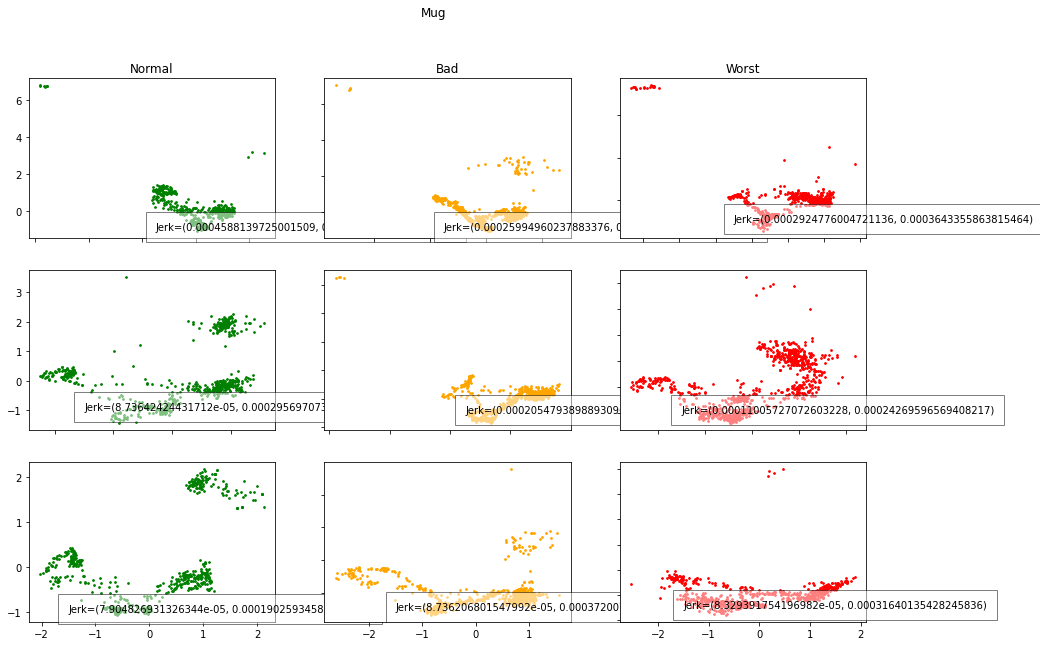

In [60]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(15,10)

fig.suptitle('Mug')

axs[0, 0].set_title('Normal')
axs[0, 1].set_title('Bad')
axs[0, 2].set_title('Worst')


exercises = ['mug', 'bottle', 'cap']
groups = ['norm','bad', 'worst']
colors = ['g', 'orange', 'r']

k = 0
e = exercises[2]
for i in range(3):
    for j in range(3): 
        poses = data[e][groups[i]][j]
        axs[j,i].scatter(poses[:,k,0],poses[:,k,1],c=colors[i],s=3)
        #axs[j,i].set_xlabel('hello')    
        axs[j,i].text(-1.5,-1,f'Jerk={njs(poses, kp=k)}',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
#         axs[j,i].text(-1.5,0,f'Dist={dtw_dist(poses,data[e]['norm'][0],kp=k)}',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
        
# ct = 0
# for ax in axs.flat:
#     ct += 1
#     ax.set(xlabel='x-label', ylabel=f'Trial {ct}')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

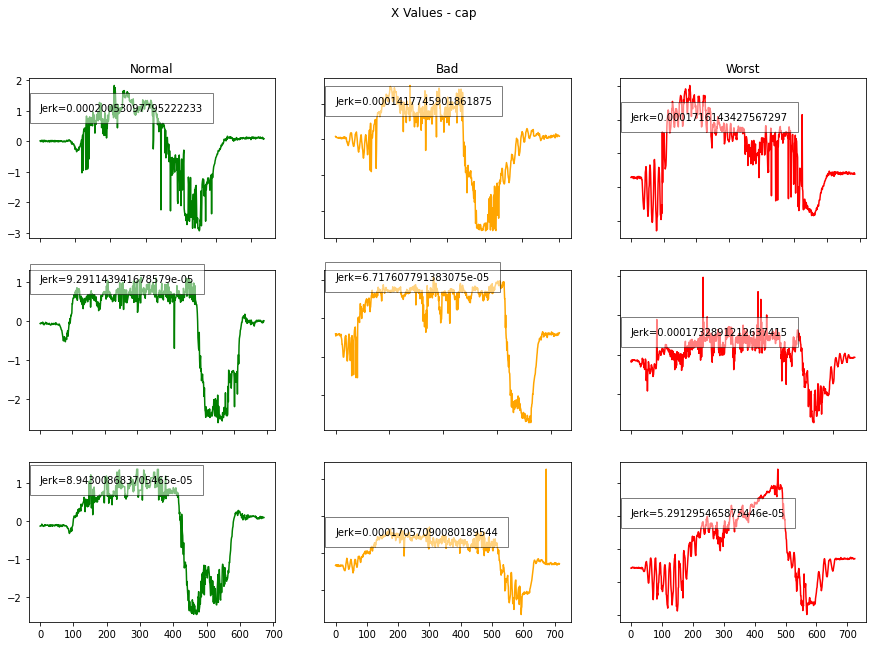

In [39]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(15,10)
fig.suptitle(f'X Values - {e}')
axs[0, 0].set_title('Normal')
axs[0, 1].set_title('Bad')
axs[0, 2].set_title('Worst')


colors = ['g', 'orange', 'r']

for i in range(3):
    for j in range(3): 
        poses = data[e][groups[i]][j]
        axs[j,i].plot(poses[:,k,0],c=colors[i])
        axs[j,i].text(-1,1,f'Jerk={njs(poses, kp=k)[0]}',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
        
# ct = 0
# for ax in axs.flat:
#     ct += 1
#     ax.set(xlabel='x-label', ylabel=f'Trial {ct}')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

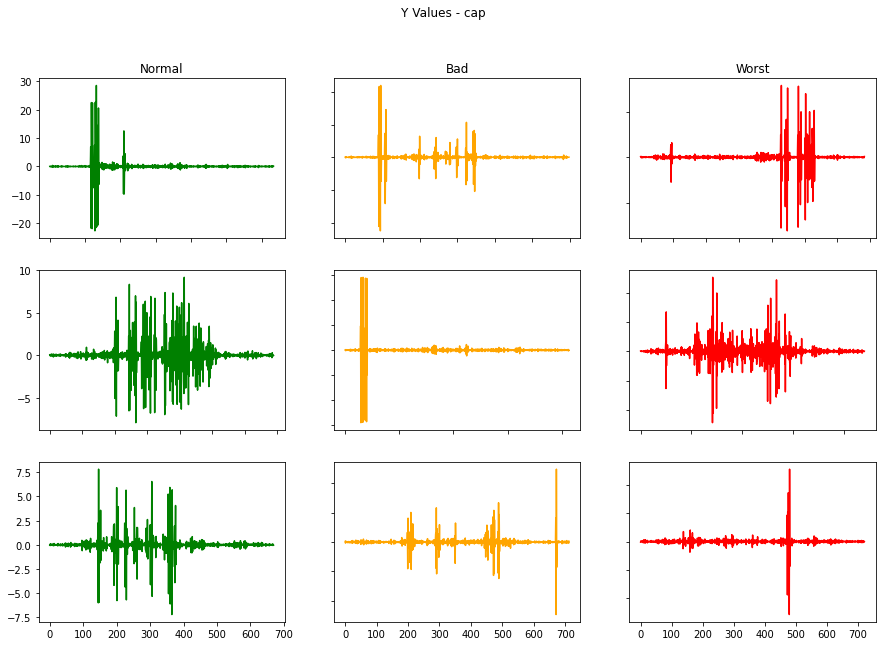

In [119]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(15,10)
fig.suptitle(f'Y Values - {e}')
axs[0, 0].set_title('Normal')
axs[0, 1].set_title('Bad')
axs[0, 2].set_title('Worst')


colors = ['g', 'orange', 'r']

for i in range(3):
    for j in range(3): 
        poses = data[e][groups[i]][j]
        axs[j,i].plot(np.diff(poses[:,k,1], n=3),c=colors[i])
        axs[j,i].text(-1,1,f'Jerk={njs(poses, kp=k)[1]}',bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})
        
# ct = 0
# for ax in axs.flat:
#     ct += 1
#     ax.set(xlabel='x-label', ylabel=f'Trial {ct}')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
plt.savefig('jerks.png')

## Sectional NJS

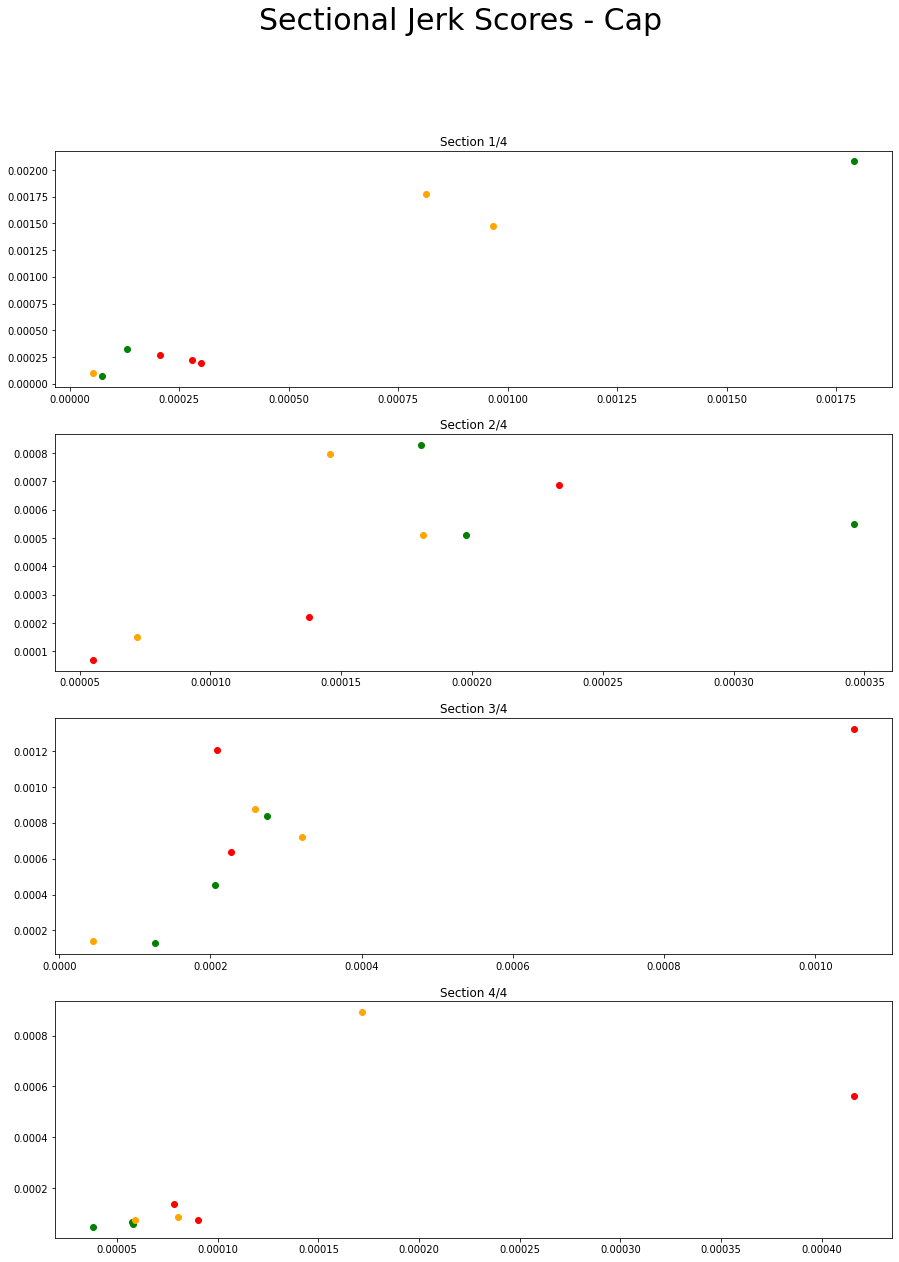

In [117]:
#split each trajectory into K sections, and plot (njx,njy) in a color coded scatter plot


e = exercises[2]
K = 4
kp = 0

fig, axs = plt.subplots(K)
fig.set_size_inches(15,20)
fig.suptitle(f'Sectional Jerk Scores - {e.capitalize()}', size=30)

sections = {}
for i in range(K):
    sections[i] = {'norm':[],'bad':[],'worst':[]}
    axs[i].set_title(f'Section {(i+1)}/{K}')

for i in range(3):
    for j in range(3): 
        poses = data[e][groups[i]][j]
        r = split_njs(poses,k=K,kp=kp)
        for c,(s,j) in enumerate(r): 
            sections[c][groups[i]].append(j)
        
#show scatter plot for comparison
for i in range(3):
    for j in range(K):
        s = sections[j]
        values = zip(*s[groups[i]])
        values = [v for v in values]
        axs[j].scatter(values[0], values[1], c=colors[i])

plt.savefig(f'Sectional Jerk Scores - {e.capitalize()}')